In [2]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PowerTransformer
import math

In [3]:
# Downloads the below csv files to a local path
# corruption.csv, cost of living.csv, richest_countries.csv, tourism.csv, unemployment.csv
path = kagglehub.dataset_download("madhurpant/world-economic-data")

In [4]:
#creates a dictionary with files names as values and keys. The keys are used as dataframe names
df_dict = {'corruption':'corruption.csv',
           'col': 'cost_of_living.csv',
           'rich_countries':'richest_countries.csv',
           'tourism':'tourism.csv',
           'unemployment':'unemployment.csv'
            }

#iterates over the dictionary of files and creates data frames
# the globals() function assigns the key as the variable 
for key,value in df_dict.items():
    globals()[key] = pd.read_csv(f'{path}/{value}')

#creates a data frame that contains data frame name, file name, columns count, and row count per file
df_info = pd.DataFrame(columns=['Name','File', 'Column_Count', 'Row_Count'])
for key in df_dict.items():
    df = pd.DataFrame([key[0]], columns = ['Name'])
    df['File'] = key[1]
    df['Column_Count'] = globals()[key[0]].shape[1]
    df['Row_Count'] = globals()[key[0]].shape[0]
    df_info = pd.concat([df_info,df],ignore_index = True)


#creates a series of all countries
countries = pd.DataFrame(columns=['country'])
for key in df_dict.items():
    countries = pd.concat([countries,globals()[key[0]]],ignore_index = True)
countries = countries['country']
countries = countries.drop_duplicates(keep="first", inplace=False)

In [5]:
df_info

,Name,File,Column_Count,Row_Count
0,corruption,corruption.csv,3,110
1,col,cost_of_living.csv,4,107
2,rich_countries,richest_countries.csv,2,50
3,tourism,tourism.csv,5,41
4,unemployment,unemployment.csv,2,64


<h2>Corruption Analysis</h2>

The below explores if a country's typical income can be used as a predictor of corruption </br>
The hypothesis is that there is a negative linear relationship between income and corruption

In [6]:
#there is a negative linear relationshop between annual income an corruption.
#as income increase corruption decreases
corruption.corr()

,annual_income,corruption_index
annual_income,1.000000,-0.916669
corruption_index,-0.916669,1.000000


In [7]:
#log transformations to use in the regression models
#This was initally done after visualizing the distributions with histograms, but moved to before so that the distributions of the
#transformed variables can be compared against the non-transformed variables

corruption['annual_income_log'] = np.log(corruption['annual_income'])
corruption['corruption_index_log'] = np.log(corruption['corruption_index'])

#power transformations to use in the regression models
pt = PowerTransformer()
annual_income_power = pd.Series(pt.fit_transform(corruption['annual_income'].to_numpy().reshape(-1, 1)).ravel(),name='annual_income_power')
corruption_index_power = pd.Series(pt.fit_transform(corruption['corruption_index'].to_numpy().reshape(-1, 1)).ravel(),name='corruption_index_power')

corruption = corruption.merge(corruption_index_power,how='left', left_index=True,right_index=True)
corruption = corruption.merge(annual_income_power,how='left', left_index=True,right_index=True)

income_list = ['annual_income', 'annual_income_log','annual_income_power']
corruption_list = ['corruption_index','corruption_index_log','corruption_index_power']

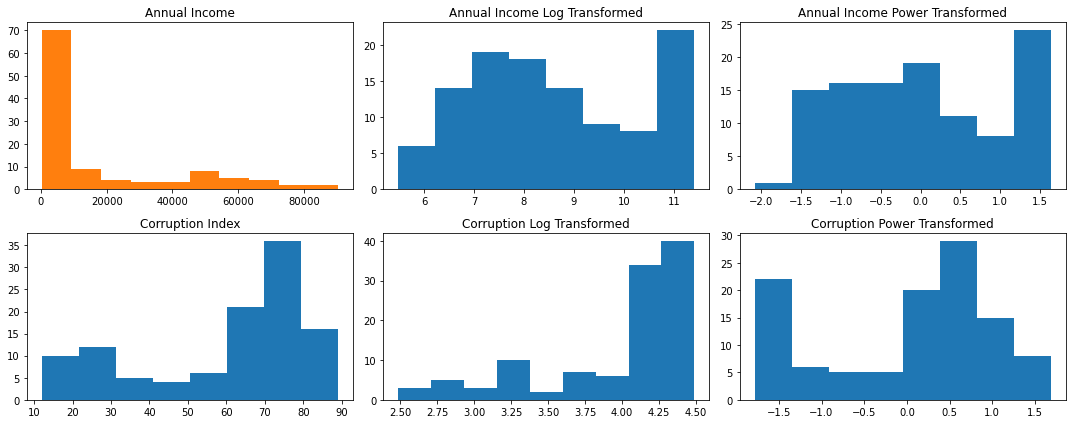

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(15, 6))

    
axs[0,0].hist(corruption['annual_income'], bins='auto')
axs[0,0].set_title('Annual Income')

axs[0,0].hist(corruption['annual_income'], bins='auto')
axs[0,0].set_title('Annual Income')

axs[0,1].hist(corruption['annual_income_log'], bins='auto')
axs[0,1].set_title('Annual Income Log Transformed')

axs[0,2].hist(corruption['annual_income_power'], bins='auto')
axs[0,2].set_title('Annual Income Power Transformed')

axs[1,0].hist(corruption['corruption_index'], bins='auto')
axs[1,0].set_title('Corruption Index')

axs[1,1].hist(corruption['corruption_index_log'], bins='auto')
axs[1,1].set_title('Corruption Log Transformed')

axs[1,2].hist(corruption['corruption_index_power'], bins='auto')
axs[1,2].set_title('Corruption Power Transformed')

plt.tight_layout()
plt.show()

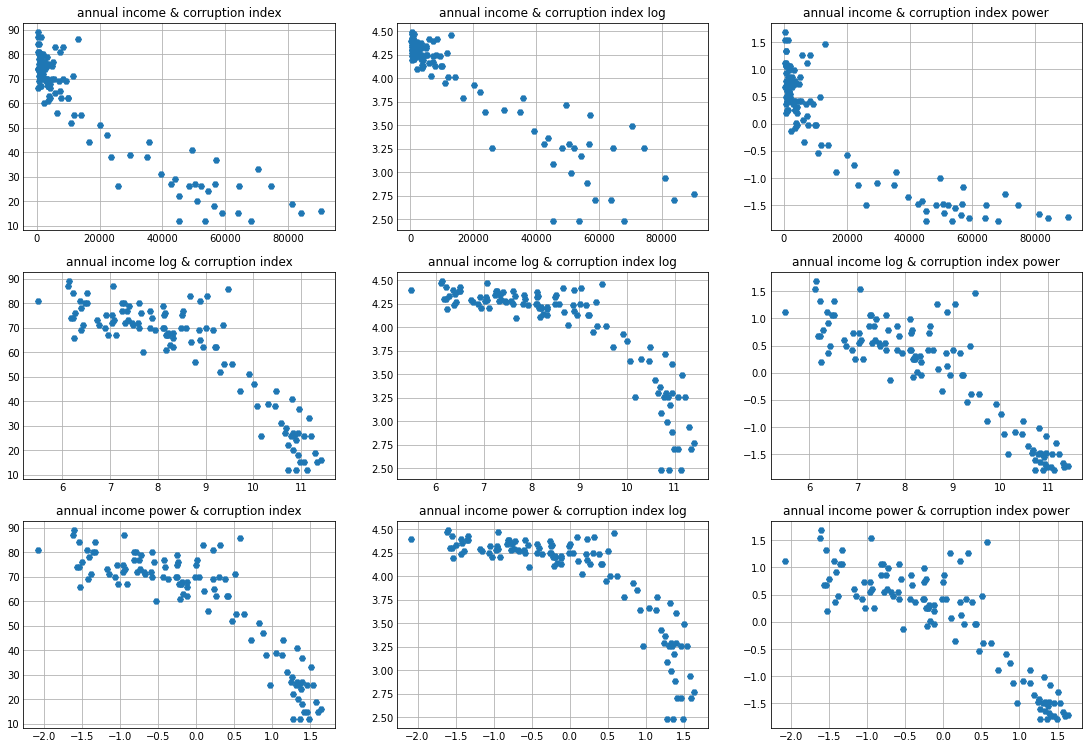

In [9]:
plt.style.use('_mpl-gallery')
fig, axs = plt.subplots(3,3,figsize=(15,10))
for num1 in range(0,3):
    for num2 in range(0,3):
        axs[num1,num2].scatter(corruption[income_list[num1]],corruption[corruption_list[num2]],marker="H")
        label = f'{income_list[num1]} & {corruption_list[num2]}'
        label = label.replace('_',' ')
        axs[num1,num2].set_title(label)
plt.show()

In [10]:
#Training and testing arrays
#Creates a dataframe with results of each x and y combination

income_list = ['annual_income', 'annual_income_log']
corruption_list = ['corruption_index','corruption_index_log']

corruption_model = pd.DataFrame(columns = ['x','y','r2','mse' ])

#inverse log transform function
def exp(x):
    return int(round(math.exp(x),0))

# Vectorize the function
vfunc = np.vectorize(exp)

for inc in income_list:
    for corrupt in corruption_list:
        X_train, X_test, y_train, y_test = train_test_split(corruption[inc], 
                                                    corruption[corrupt], random_state=42)
        #converting the training and test data to arrays
        x = corruption[inc].to_numpy().reshape(-1,1)
        y = corruption[corrupt].to_numpy().reshape(-1,1)
        X_train = X_train.to_numpy().reshape(-1, 1)
        y_train = y_train.to_numpy().reshape(-1, 1)
        X_test = X_test.to_numpy().reshape(-1,1)
        y_test = y_test.to_numpy().reshape(-1,1)
        reg = LinearRegression().fit(X_train,y_train)
        df = pd.DataFrame(data=[corruption[inc].name],columns = ['x'])
        df['y'] = corruption[corrupt].name
        df['r2'] = round(reg.score(x,y),4)
        if 'log' in corruption[corrupt].name:
            df['mse'] = round(mean_squared_error(vfunc(y), vfunc(reg.predict(x))),2)
        else:
            df['mse'] = round(mean_squared_error(y, reg.predict(x)),2)
        #df['mse'] = round(mean_squared_error(y, reg.predict(x)),2)
        corruption_model = pd.concat([corruption_model,df],ignore_index = True)

In [11]:
#prints a data frame of r2 and mse per x and y combo
#the annual income independent variable and corruption index log dependent variable combo predicts the best
corruption_model

,x,y,r2,mse
0,annual_income,corruption_index,0.8397,78.05
1,annual_income,corruption_index_log,0.8521,56.53
2,annual_income_log,corruption_index,0.7637,115.09
3,annual_income_log,corruption_index_log,0.6934,246.95


In [12]:
# The model with the lowest MSE is x = annual income and y = corruption index log and 
inc = 'annual_income'
corrupt = 'corruption_index_log'


X_train, X_test, y_train, y_test = train_test_split(corruption[inc], 
                                                    corruption[corrupt], random_state=42)
#converting the training and test data to arrays
x = corruption[inc].to_numpy().reshape(-1,1)
y = corruption[corrupt].to_numpy().reshape(-1,1)
X_train = X_train.to_numpy().reshape(-1, 1)
y_train = y_train.to_numpy().reshape(-1, 1)
X_test = X_test.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)
reg = LinearRegression().fit(X_train,y_train)

In [13]:
#Uses the slope and intercept to calculate the predicted corruption index based on income
#Set the income variable to some value and execute the block for the result 

income = 50000

#comment or uncomment when the log corruption index is used as the dependent variable
pred_corpt = round(math.exp(reg.intercept_[0]+(reg.coef_[0][0])*income),0)

print(f'The predicted corruption index is {int(pred_corpt)}'),
print('Actual data for countries with a corruption index between -+3 of the predicted corruption index')
corruption[['country','annual_income','corruption_index']].loc[(corruption['corruption_index']>=pred_corpt-3)&(corruption['corruption_index']<=pred_corpt+3)] 

The predicted corruption index is 27
Actual data for countries with a corruption index between -+3 of the predicted corruption index


,country,annual_income,corruption_index
11,Hong Kong,54450,24
12,Austria,52210,26
13,Canada,48310,26
14,Estonia,25970,26
15,Iceland,64410,26
16,Ireland,74520,26
17,Australia,56760,27
18,Belgium,50510,27
19,Japan,42620,27
20,France,43880,29


In [14]:
hof = pd.read_excel('hofstede_imputed.xlsx')
corruption = pd.merge(corruption,hof,left_on='country',right_on='Country')
corruption = corruption[['country',
            'annual_income',
            'annual_income_log',
            'corruption_index',
            'corruption_index_log',
            'pdi',
            'idv',
            'mas',
            'uai',
            'ltowvs',
            'ivr']]

In [15]:
corruption.corr()

,annual_income,annual_income_log,corruption_index,corruption_index_log,pdi,idv,mas,uai,ltowvs,ivr
annual_income,1.000000,0.869401,-0.917059,-0.923564,-0.612265,0.688227,-0.023724,-0.174721,0.360294,0.151474
annual_income_log,0.869401,1.000000,-0.874257,-0.832481,-0.447298,0.604444,0.056109,0.043405,0.414583,0.077457
corruption_index,-0.917059,-0.874257,1.000000,0.977358,0.583622,-0.688946,0.041209,0.176495,-0.436240,-0.111547
corruption_index_log,-0.923564,-0.832481,0.977358,1.000000,0.622612,-0.685658,0.104042,0.239987,-0.405720,-0.148249
pdi,-0.612265,-0.447298,0.583622,0.622612,1.000000,-0.632132,0.076351,0.153228,-0.265044,-0.082142
idv,0.688227,0.604444,-0.688946,-0.685658,-0.632132,1.000000,0.055217,-0.145906,0.158507,0.179531
mas,-0.023724,0.056109,0.041209,0.104042,0.076351,0.055217,1.000000,0.125302,0.099874,-0.013752
uai,-0.174721,0.043405,0.176495,0.239987,0.153228,-0.145906,0.125302,1.000000,0.098262,-0.142510
ltowvs,0.360294,0.414583,-0.436240,-0.405720,-0.265044,0.158507,0.099874,0.098262,1.000000,-0.485704
ivr,0.151474,0.077457,-0.111547,-0.148249,-0.082142,0.179531,-0.013752,-0.142510,-0.485704,1.000000


In [29]:
inc = ['annual_income','pdi','idv','mas','uai','ltowvs','ivr']
corrupt = 'corruption_index_log'


X_train, X_test, y_train, y_test = train_test_split(corruption[inc], 
                                                    corruption[corrupt], random_state=42)
#converting the training and test data to arrays
#x = corruption[inc].to_numpy().reshape(-1,1)
y = corruption[corrupt].to_numpy().reshape(-1,1)
#X_train = X_train.to_numpy().reshape(-1, 1)
y_train = y_train.to_numpy().reshape(-1, 1)
#X_test = X_test.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)
reg = LinearRegression().fit(X_train,y_train)
round(reg.score(X_train,y_train),4)

0.88

In [30]:
round(mean_squared_error(vfunc(y_train), vfunc(reg.predict(X_train))),2)

59.24